## Training a CNN for classification

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.data.sampler import SubsetRandomSampler

import time
import os
import requests
import random
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [2]:
%pwd

'c:\\Users\\sirifris\\OneDrive - OsloMet\\Dokumenter\\PHD\\Article 3\\poli_reco'

In [71]:
# Define data transformations for augmentation and normalization
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

In [107]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # resize all images to 128x128
    transforms.RandomHorizontalFlip(), # randomly flip horizontally...
    transforms.RandomVerticalFlip(), # ... and vertically ...
    transforms.RandomRotation(30), # ... and rotate
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Normalizing using the numbers recommended when working with ResNet18
])

In [105]:
# data_dir = 'data'

# # Creating data loaders
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# class_names = image_datasets['train'].classes

Displaying one random image from Bent Høie: Bent Høie_100.jpg


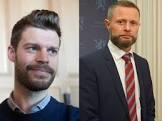

Displaying one random image from Donald Trump: Donald Trump_55.jpg


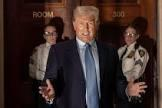

Displaying one random image from Erna Solberg: Erna Solberg_5.jpg


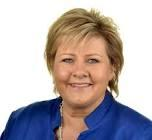

Displaying one random image from Joe Biden: Joe Biden_114.jpg


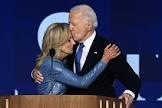

Displaying one random image from Jonas Gahr Støre: Jonas Gahr Støre_119.jpg


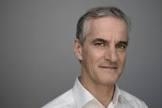

Displaying one random image from Lan Marie Berg: Lan Marie Berg_122.jpg


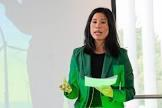

Displaying one random image from Sylvi Lysthaug: Sylvi Lysthaug_119.jpg


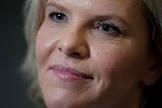

In [127]:
data_dir = 'data'

subfolders = [f.name for f in os.scandir(data_dir) if f.is_dir()]

# Iterate over each subfolder (each species)
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)

    # Get a list of all image files in the subfolder
    images = [f for f in os.listdir(subfolder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a random image from the subfolder
    random_image = random.choice(images)

    # Full path to the selected image
    image_path = os.path.join(subfolder_path, random_image)

    # Open and display the image<
    image = Image.open(image_path)
    print(f"Displaying one random image from {subfolder}: {random_image}")
    display(image)

In [128]:
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [129]:
from sklearn.model_selection import train_test_split

# Extract indices and corresponding labels
indices = np.arange(len(dataset))
labels = np.array([label for _, label in dataset.imgs])

# Split into training (70%) and combined validation/test (30%)
train_indices, val_test_indices, train_labels, val_test_labels = train_test_split(
    indices, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the combined validation/test set into validation (15%) and test (15%)
val_indices, test_indices, _, _ = train_test_split(
    val_test_indices, val_test_labels, test_size=0.5, stratify=val_test_labels, random_state=42)

# Create samplers for each set
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoader for each set
train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler, num_workers=2)

In [ ]:
# # Load the pre-trained ResNet-18 model
# model = models.resnet18(pretrained=True)

# # Freeze all layers except the final classification layer
# for name, param in model.named_parameters():
#     if "fc" in name:  # Unfreeze the final classification layer
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters

# model = model.to(device)

In [130]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the fully connected layer for 7 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Using a scheduler to adjust the learning rate dynamically
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

C:\Users\sirifris\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sirifris\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
# # Training loop
# num_epochs = 20
# for epoch in range(num_epochs):
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             model.train()
#         else:
#             model.eval()

#         running_loss = 0.0
#         running_corrects = 0

#         for inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()

#             with torch.set_grad_enabled(phase == 'train'):
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / dataset_sizes[phase]
#         epoch_acc = running_corrects.double() / dataset_sizes[phase]

#         print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# print("Training complete!")

train Loss: 3.3157 Acc: 0.1355
val Loss: 2.1436 Acc: 0.3125
train Loss: 2.2049 Acc: 0.2710
val Loss: 1.7550 Acc: 0.3839
train Loss: 2.0061 Acc: 0.2796
val Loss: 1.8445 Acc: 0.3393
train Loss: 1.9630 Acc: 0.3097
val Loss: 1.5911 Acc: 0.4286
train Loss: 1.7861 Acc: 0.3484
val Loss: 1.6122 Acc: 0.4554
train Loss: 1.7831 Acc: 0.3290
val Loss: 1.5107 Acc: 0.4464
train Loss: 1.6332 Acc: 0.4022
val Loss: 1.3616 Acc: 0.5179
train Loss: 1.6648 Acc: 0.3677
val Loss: 1.2692 Acc: 0.5625
train Loss: 1.6286 Acc: 0.3892
val Loss: 1.3971 Acc: 0.5536
train Loss: 1.7888 Acc: 0.3935
val Loss: 1.3063 Acc: 0.5179
train Loss: 1.6054 Acc: 0.4129
val Loss: 1.3820 Acc: 0.4732
train Loss: 1.5875 Acc: 0.4366
val Loss: 1.2269 Acc: 0.5179
train Loss: 1.5788 Acc: 0.4538
val Loss: 1.4324 Acc: 0.4821
train Loss: 1.6154 Acc: 0.4237
val Loss: 1.3484 Acc: 0.5714
train Loss: 1.5634 Acc: 0.4430
val Loss: 1.4301 Acc: 0.5179
train Loss: 1.5280 Acc: 0.4731
val Loss: 1.1918 Acc: 0.5893
train Loss: 1.5738 Acc: 0.4602
val Loss:

In [131]:
# Training loop
num_epochs = 15 # Doing 10 epochs
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.sampler)
    train_acc = correct / total

    scheduler.step()

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/15, Train Loss: 2.0597, Train Acc: 0.3153, Val Acc: 0.2619
Epoch 2/15, Train Loss: 1.4437, Train Acc: 0.4694, Val Acc: 0.2667
Epoch 3/15, Train Loss: 1.0956, Train Acc: 0.5949, Val Acc: 0.2857
Epoch 4/15, Train Loss: 1.1105, Train Acc: 0.5918, Val Acc: 0.5048
Epoch 5/15, Train Loss: 0.8352, Train Acc: 0.7204, Val Acc: 0.2524
Epoch 6/15, Train Loss: 0.6162, Train Acc: 0.7878, Val Acc: 0.6333
Epoch 7/15, Train Loss: 0.4885, Train Acc: 0.8378, Val Acc: 0.6762
Epoch 8/15, Train Loss: 0.4245, Train Acc: 0.8633, Val Acc: 0.7143
Epoch 9/15, Train Loss: 0.4014, Train Acc: 0.8694, Val Acc: 0.7143
Epoch 10/15, Train Loss: 0.3141, Train Acc: 0.8918, Val Acc: 0.7000
Epoch 11/15, Train Loss: 0.3134, Train Acc: 0.8980, Val Acc: 0.7333
Epoch 12/15, Train Loss: 0.2662, Train Acc: 0.9153, Val Acc: 0.7333
Epoch 13/15, Train Loss: 0.2657, Train Acc: 0.9194, Val Acc: 0.7905
Epoch 14/15, Train Loss: 0.2481, Train Acc: 0.9214, Val Acc: 0.7381
Epoch 15/15, Train Loss: 0.2693, Train Acc: 0.9163, Val A

In [76]:
# Save the model
# torch.save(model.state_dict(), 'politician_classification_model.pth')

In [77]:
# # Load the saved model
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
# model.load_state_dict(torch.load('politician_classification_model.pth'))
# model.eval()

# # Create a new model with the correct final layer
# new_model = models.resnet18(pretrained=True)
# new_model.fc = nn.Linear(new_model.fc.in_features, 7)  # Adjust to match the desired output units

# # Copy the weights and biases from the loaded model to the new model
# new_model.fc.weight.data = model.fc.weight.data[0:2]  
# new_model.fc.bias.data = model.fc.bias.data[0:2]

In [84]:
# # Load and preprocess the unseen image
# image_path = 'donald_test.jpg'  # Replace with the path to your image
# image = Image.open(image_path)
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
# input_tensor = preprocess(image)
# input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# # Perform inference
# with torch.no_grad():
#     output = new_model(input_batch)

# # Get the predicted class
# _, predicted_class = output.max(1)

# # Map the predicted class to the class name
# class_names = [ 'Jonas Gahr Støre', 'Erna Solberg', 'Bent Høie', 'Lan Marie Berg', 'Sylvi Lysthaug', 'Donald Trump','Joe Biden' ] 
# predicted_class_name = class_names[predicted_class.item()]

# print(f'The predicted class is: {predicted_class_name}')

The predicted class is: Erna Solberg


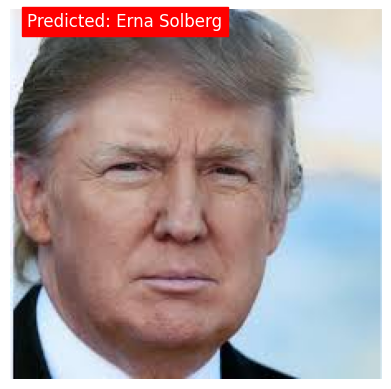

In [86]:
# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [132]:
# Loading the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on the test data
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy()) # Change to GPU
        all_labels.extend(labels.cpu().numpy()) # Change to GPU

test_acc = test_correct / test_total
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7619


In [133]:
from sklearn.metrics import confusion_matrix, classification_report

# Cassification report:
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

                  precision    recall  f1-score   support

       Bent Høie       0.81      0.83      0.82        30
    Donald Trump       0.72      0.70      0.71        30
    Erna Solberg       0.80      0.93      0.86        30
       Joe Biden       0.67      0.73      0.70        30
Jonas Gahr Støre       0.68      0.50      0.58        30
  Lan Marie Berg       0.88      0.93      0.90        30
  Sylvi Lysthaug       0.75      0.70      0.72        30

        accuracy                           0.76       210
       macro avg       0.76      0.76      0.76       210
    weighted avg       0.76      0.76      0.76       210

